# Вычисление центральностей у графа из друзей и друзей друзей в социальной сети ВК

Работу выполнили студенты группы БСМО-11-25:

* Аршинов Владислав
* Елохин Валерий
* Савин Даниил
* Якушенко Иван



-----
Импортируем необходимые библиотеки

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque, defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import warnings

Загружаем данные

In [42]:
data = pd.read_csv('friends.csv', encoding='utf-8')
data

,source,target
0,340121125,11582761
1,340121125,23810143
2,340121125,76142574
3,340121125,95176713
4,340121125,99228440
...,...,...
157104,832324541,886453244
157105,832324541,896549934
157106,832324541,1033797901
157107,832324541,1066367739


Убираем дубликаты строк в данных

In [43]:
# Создаем столбец с отсортированными парами для идентификации дубликатов
data['sorted_pair'] = data.apply(lambda row: ','.join(sorted([str(row['source']), str(row['target'])])), axis=1)

# Удаляем дубликаты по отсортированным парам, сохраняя первую встреченную строку
data = data.drop_duplicates(subset=['sorted_pair'])

# Удаляем временный столбец
data = data.drop('sorted_pair', axis=1)
data = data[:5000]
data

,source,target
0,340121125,11582761
1,340121125,23810143
2,340121125,76142574
3,340121125,95176713
4,340121125,99228440
...,...,...
4995,219305476,236690140
4996,219305476,238384014
4997,219305476,240098981
4998,219305476,246392839


Строим граф на основе данных

In [44]:
G = nx.from_pandas_edgelist(data)

Визуализируем граф

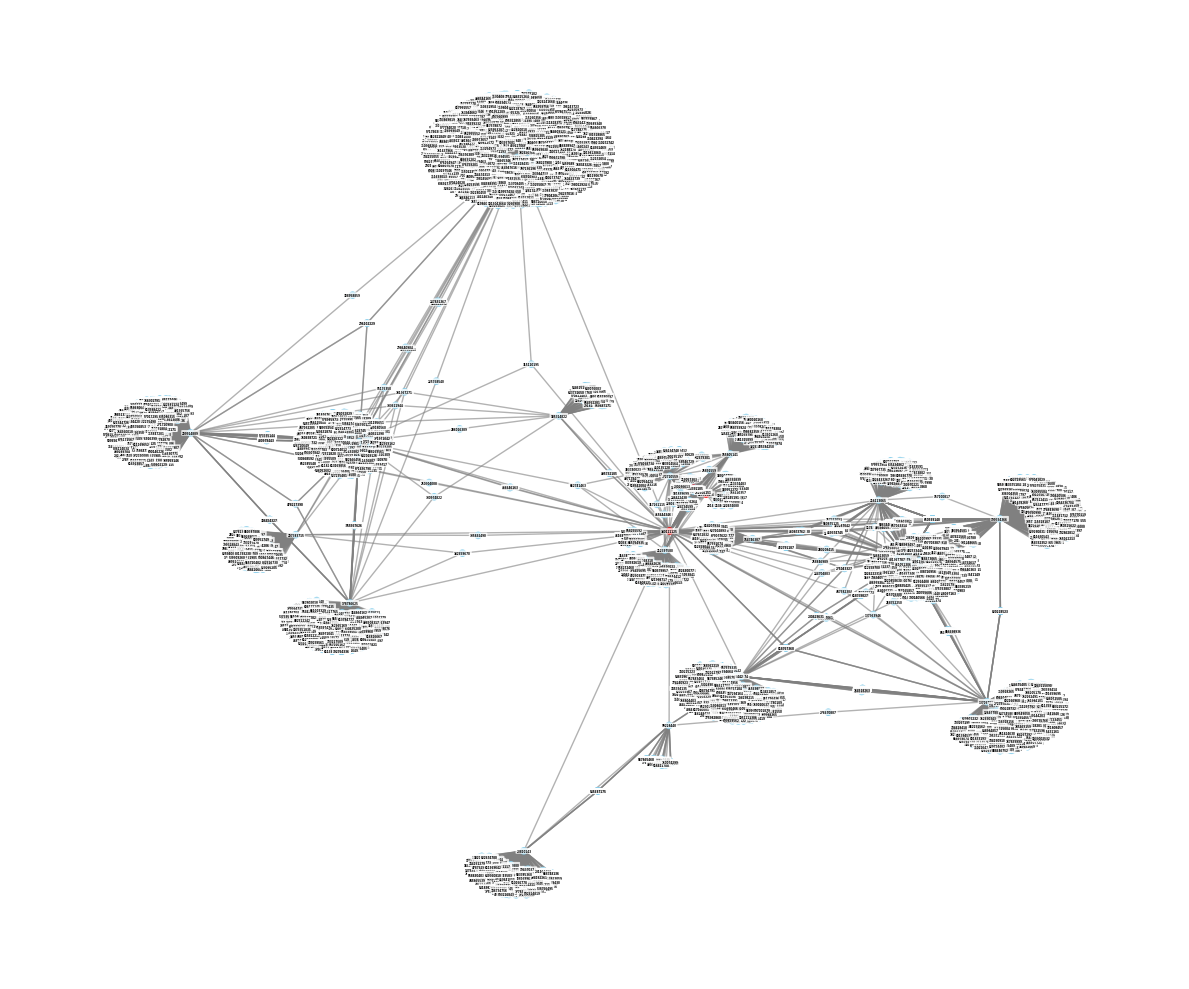

In [45]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)

node_colors = []
for node in G.nodes():
    if node in (488243736, 326866301, 340121125, 219305476):
        node_colors.append("red")
    else:
        node_colors.append("skyblue")

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20,
                       alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6, width=1)
nx.draw_networkx_labels(G, pos, font_size=2, font_family='DejaVu Sans',
                       font_weight='bold', bbox=dict(boxstyle="round,pad=0.3",
                       facecolor="white", edgecolor="none", alpha=0.8))
plt.axis('off')
plt.tight_layout()
plt.savefig("graph.png", dpi=1000)
plt.show()

## Центральность по посредничеству

*Центральность по посредничеству (betweenness centrality)* — это показатель, который характеризует, насколько важную роль определённый узел играет на пути между другими узлами (определённый узел лежит на кратчайшем пути между двумя другими узлами).

Если у какого-либо узла высокий показатель центральности по посредничеству, тогда он — единственная связь между различными частями сети.

Узел с наибольшей степенью посредничества может контролировать наибольшее число каналов коммуникации.

Реализуем собственную функцию оценки центральности по посредничеству

In [46]:
def my_betweenness_centrality(G, endpoints=False):
    # Создаем словарь для хранения центральности каждого узла
    betweenness = {node: 0.0 for node in G.nodes()}
    nodes = list(G.nodes()) # Список узлов
    n = len(nodes) # Длина списка

    # Основной алгоритм
    for source in nodes:
        # Структура данных для обхода графа в ширину
        S = []  # Стек для порядка обхода
        dist = {source: 0}  # Расстояния
        sigma = defaultdict(int)  # Количество кратчайших путей
        sigma[source] = 1
        pred = defaultdict(list)  # Предшественники для каждого узла на кратчайших путях
        queue = deque([source])  # Очередь для алгоритма поиска в ширину

        # Процесс обхода в ширину
        while queue:
            # Обработка текущего узла
            current = queue.popleft()
            S.append(current)

            # Обход всех соседей
            for neighbor in G.neighbors(current):
                # Если узел встречается впервые
                if neighbor not in dist:
                    dist[neighbor] = dist[current] + 1 # Увеличиваем расстояние
                    queue.append(neighbor) # Добавляем в очередь

                # Если найден кратчайший путь
                if dist[neighbor] == dist[current] + 1:
                    sigma[neighbor] += sigma[current] # Увеличиваем количество путей
                    pred[neighbor].append(current) # Запоминаем предшественника

        # Обратный проход
        delta = defaultdict(float)
        # Идем от самых дальних узлов к источнику
        while S:
            current = S.pop()
            for predecessor in pred[current]:
                # "Вклад" пропорционально количеству путей
                # (Доля кратчайших путей через предшественника X "вклад" текущего узла)
                delta[predecessor] += (sigma[predecessor] / sigma[current]) * (1 + delta[current])
            #Добавляем вычисленный вклад в общую центральность узла
            if current != source:
                betweenness[current] += delta[current]
                # Учитываем все узлы, включая конечные точки путей
                if endpoints:
                    betweenness[current] += sigma[current]

    # Нормализация
    if n <= 2:
        scale = 1.0
    else:
        scale = 1.0 / ((n - 1) * (n - 2))

    # Нормализация результатов
    for node in betweenness:
        betweenness[node] *= scale

    return betweenness

Используем самописную функцию

In [47]:
test = my_betweenness_centrality(G)
test

{340121125: 0.6153547633358206,
 11582761: 0.5373449943283639,
 23810143: 0.07680384074391225,
 76142574: 0.11919561443403691,
 95176713: 0.12199810389178446,
 99228440: 0.009714553652748424,
 137037837: 0.168556324559019,
 154746387: 0.02144579885584896,
 155805141: 0.034565821431532924,
 172710559: 0.029179960793245856,
 178786625: 0.12049592899686304,
 181379424: 0.14254419770855,
 185314822: 0.019369307361491554,
 199334366: 0.13470385554856906,
 207383715: 0.05578386054429795,
 209914889: 0.13113820432512352,
 212397580: 0.03712984168539742,
 216123065: 0.04952868895048554,
 219305476: 0.01649608712229014,
 228061240: 0.0,
 228741614: 0.0,
 229814797: 0.0,
 232094840: 0.0,
 236690140: 0.0,
 238384014: 0.0,
 240098981: 0.0,
 240443780: 0.0,
 243040657: 0.0,
 244704883: 0.0016198060165265086,
 248652763: 0.0001982502079976853,
 250304008: 0.0,
 252606151: 0.0,
 255458851: 0.0,
 256262373: 0.0,
 257066830: 0.00011662556366069936,
 257332093: 0.00011662556366069936,
 258611275: 0.0,
 

Запуск алгоритма через готовую функцию (сверка результатов)

In [48]:
bc = nx.betweenness_centrality(G)

print("Центральность по посредничеству:")
for node, score in bc.items():
    print(f'{node}: {score}')

Центральность по посредничеству:
340121125: 0.6153547633358206
11582761: 0.5373449943283639
23810143: 0.07680384074391225
76142574: 0.11919561443403691
95176713: 0.12199810389178446
99228440: 0.009714553652748424
137037837: 0.168556324559019
154746387: 0.02144579885584896
155805141: 0.034565821431532924
172710559: 0.029179960793245856
178786625: 0.12049592899686304
181379424: 0.14254419770855
185314822: 0.019369307361491554
199334366: 0.13470385554856906
207383715: 0.05578386054429795
209914889: 0.13113820432512352
212397580: 0.03712984168539742
216123065: 0.04952868895048554
219305476: 0.01649608712229014
228061240: 0.0
228741614: 0.0
229814797: 0.0
232094840: 0.0
236690140: 0.0
238384014: 0.0
240098981: 0.0
240443780: 0.0
243040657: 0.0
244704883: 0.0016198060165265086
248652763: 0.0001982502079976853
250304008: 0.0
252606151: 0.0
255458851: 0.0
256262373: 0.0
257066830: 0.00011662556366069936
257332093: 0.00011662556366069936
258611275: 0.0
258846989: 0.0028183150946255353
260771135

Топ-10 узлов (самописная функция)

In [49]:
for i, pair in enumerate(sorted([(k, v) for k, v in test.items()], key=lambda p: p[1], reverse=True)[:10]):
  print(f"{i+1:2}: {pair[0]}\t(Центральность = {pair[1]})")

 1: 340121125	(Центральность = 0.6153547633358206)
 2: 11582761	(Центральность = 0.5373449943283639)
 3: 137037837	(Центральность = 0.168556324559019)
 4: 181379424	(Центральность = 0.14254419770855)
 5: 199334366	(Центральность = 0.13470385554856906)
 6: 209914889	(Центральность = 0.13113820432512352)
 7: 95176713	(Центральность = 0.12199810389178446)
 8: 178786625	(Центральность = 0.12049592899686304)
 9: 76142574	(Центральность = 0.11919561443403691)
10: 23810143	(Центральность = 0.07680384074391225)


Топ-10 вершин (готовая функция)

In [50]:
for i, pair in enumerate(sorted([(k, v) for k, v in bc.items()], key=lambda p: p[1], reverse=True)[:10]):
  print(f"{i+1:2}: {pair[0]}\t(Центральность = {pair[1]})")

 1: 340121125	(Центральность = 0.6153547633358206)
 2: 11582761	(Центральность = 0.5373449943283639)
 3: 137037837	(Центральность = 0.168556324559019)
 4: 181379424	(Центральность = 0.14254419770855)
 5: 199334366	(Центральность = 0.13470385554856906)
 6: 209914889	(Центральность = 0.13113820432512352)
 7: 95176713	(Центральность = 0.12199810389178446)
 8: 178786625	(Центральность = 0.12049592899686304)
 9: 76142574	(Центральность = 0.11919561443403691)
10: 23810143	(Центральность = 0.07680384074391225)


## Центральность по близости

Здесь будет написана своя функция по рассчету центральности по близости для графа. Центральность по близости — показатель того, насколько близко узел расположен к остальным узлам сети. В нашей ситуации центральность по близости показывает близость человека ко всем остальным пользователям в сети.

In [51]:
def custom_closeness_centrality(G):
    closeness = {}
    # Реализуем поиск в ширину для нахождения расстояний
    for node in G.nodes():
        # Словарь distances будет хранить расстояния от текущего узла до остальных
        distances = {node: 0}
        queue = [node]

        while queue:
            current = queue.pop(0)
            # Для текущего узла перебираем всех соседей
            for neighbor in G.neighbors(current):
                # Проверяем, не посещали ли мы уже этого соседа
                if neighbor not in distances:
                    # Записываем расстояние до соседа
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

        # Считаем сумму всех расстояний
        total_distance = sum(distances.values())
        reachable_count = len(distances)

        # Рассчитываем центральность по формуле
        if total_distance > 0:
            closeness[node] = (reachable_count - 1) / total_distance
        else:
            closeness[node] = 0

    return closeness

Теперь считаем центральности через выше написанную функцию и встроенную функцию.

In [52]:
custom_close_centr = custom_closeness_centrality(G)
lib_close_centr = nx.closeness_centrality(G)

В этой ячейке выводим 10 самых централизованных вершин по библиотечной функции

In [53]:
for i, pair in enumerate(sorted([(k, v) for k, v in lib_close_centr.items()], key=lambda p: p[1], reverse=True)[:10]):
  print(f"{i+1:2}: {pair[0]}\t(Центральность = {pair[1]})")

 1: 340121125	(Центральность = 0.5051963680122525)
 2: 11582761	(Центральность = 0.43888994487739974)
 3: 95176713	(Центральность = 0.414691091954023)
 4: 315110195	(Центральность = 0.38464101282691987)
 5: 181379424	(Центральность = 0.3697357886309047)
 6: 258846989	(Центральность = 0.3659851006498653)
 7: 199334366	(Центральность = 0.3641668638120022)
 8: 244704883	(Центральность = 0.3617421275262416)
 9: 209914889	(Центральность = 0.35968533374873435)
10: 178786625	(Центральность = 0.3581233036060489)


В этой ячейке выводим 10 самых централизованных вершин по собственной функции

In [54]:
for i, pair in enumerate(sorted([(k, v) for k, v in custom_close_centr.items()], key=lambda p: p[1], reverse=True)[:10]):
  print(f"{i+1:2}: {pair[0]}\t(Центральность = {pair[1]})")

 1: 340121125	(Центральность = 0.5051963680122525)
 2: 11582761	(Центральность = 0.43888994487739974)
 3: 95176713	(Центральность = 0.414691091954023)
 4: 315110195	(Центральность = 0.38464101282691987)
 5: 181379424	(Центральность = 0.3697357886309047)
 6: 258846989	(Центральность = 0.3659851006498653)
 7: 199334366	(Центральность = 0.3641668638120022)
 8: 244704883	(Центральность = 0.3617421275262416)
 9: 209914889	(Центральность = 0.35968533374873435)
10: 178786625	(Центральность = 0.3581233036060489)


## Центральность по собственному вектору

Алгоритм центральности по собственному вектору определяет важность вершины на основе важности её соседей.

Вершина считается тем более влиятельной, чем больше у неё связей с другими важными вершинами. Это рекурсивное понятие: важная вершина связана с другими важными вершинами. Математически это соответствует нахождению главного собственного вектора матрицы смежности графа, где каждая компонента вектора представляет центральность соответствующей вершины.

Проще говоря: "важность вершины = средняя важность её соседей".

Для начала, воспользуемся готовой библиотечной реализацией алгоритма, чтобы был ориентир

In [55]:
centralities_lib = nx.eigenvector_centrality(G,10000)
centralities_lib

{340121125: 0.021449000932056938,
 11582761: 0.7067947193652604,
 23810143: 0.000654536634748935,
 76142574: 0.0007742477310515702,
 95176713: 0.027801404183807915,
 99228440: 0.0006323493978127752,
 137037837: 0.0009414450027589242,
 154746387: 0.0007027738488929075,
 155805141: 0.001059893532002795,
 172710559: 0.001041768607265142,
 178786625: 0.004360272392674749,
 181379424: 0.0014444101848193054,
 185314822: 0.0016700438375131937,
 199334366: 0.0011103971973916674,
 207383715: 0.0022221890032781554,
 209914889: 0.005832114190473224,
 212397580: 0.0008798039865305819,
 216123065: 0.0009595320794115899,
 219305476: 0.00072833143741408,
 228061240: 0.0006018386139667858,
 228741614: 0.0006104327631541952,
 229814797: 0.0005834260856929848,
 232094840: 0.0005933944941768346,
 236690140: 0.0006293150823999177,
 238384014: 0.0006293150823999177,
 240098981: 0.0006521236623557178,
 240443780: 0.0005933944941768346,
 243040657: 0.0005992480257282789,
 244704883: 0.0006422547004515355,
 2

Теперь создадим свою реализацию и прогоним данные через нее

In [56]:
def eigenvector_centrality(df, max_iter=100, tol=1e-6):
    """
    Оптимизированная версия с экономией памяти
    """
    # Используем более эффективное создание mapping
    unique_nodes = np.union1d(df['source'].unique(), df['target'].unique())
    node_to_idx = {node: i for i, node in enumerate(unique_nodes)}
    n = len(unique_nodes)

    # Строим матрицу смежности более эффективно
    sources = df['source'].map(node_to_idx).values
    targets = df['target'].map(node_to_idx).values

    # Создаем разреженную матрицу
    A = csr_matrix((np.ones(len(sources), dtype=np.float32),
                   (sources, targets)), shape=(n, n))

    # Для неориентированного графа - делаем симметричной
    A = A + A.T
    A.data = np.ones_like(A.data)  # Убираем веса, оставляем только факт связи

    # Оптимизированный степенной метод
    n = A.shape[0]
    x = np.ones(n, dtype=np.float32) / n  # Начальное приближение

    for i in range(max_iter):
        # Умножение разреженной матрицы на вектор
        Ax = A.dot(x)

        # Нормализация
        norm = np.sqrt(np.dot(Ax, Ax))  # L2 норма

        if norm < 1e-12:
            break

        x_new = Ax / norm

        # Проверка сходимости
        if np.sqrt(np.dot(x_new - x, x_new - x)) < tol:
            x = x_new
            print(f"Сходимость достигнута на итерации {i+1}")
            break

        x = x_new

    centrality = np.abs(x)
    # centrality = centrality / centrality.sum()  # Нормализация

    return dict(zip(unique_nodes, centrality))

In [57]:
centralities_custom = eigenvector_centrality(data, 10000)
centralities_custom

{np.int64(15825): np.float32(0.018738765),
 np.int64(17106): np.float32(0.018738765),
 np.int64(18197): np.float32(0.018738765),
 np.int64(18971): np.float32(0.018738765),
 np.int64(20253): np.float32(0.018738765),
 np.int64(28005): np.float32(0.018738765),
 np.int64(52650): np.float32(0.018738765),
 np.int64(96319): np.float32(0.018738765),
 np.int64(130325): np.float32(0.018738765),
 np.int64(133906): np.float32(0.018738765),
 np.int64(136020): np.float32(0.018738765),
 np.int64(153683): np.float32(0.018738765),
 np.int64(216936): np.float32(2.042216e-05),
 np.int64(242826): np.float32(0.018738765),
 np.int64(268677): np.float32(0.018738765),
 np.int64(275628): np.float32(0.018738765),
 np.int64(331879): np.float32(0.018738765),
 np.int64(335668): np.float32(0.018738765),
 np.int64(338764): np.float32(0.018738765),
 np.int64(345079): np.float32(0.018738765),
 np.int64(418523): np.float32(0.018738765),
 np.int64(431506): np.float32(0.018738765),
 np.int64(556308): np.float32(0.0187387

Составим топ-10 самых "влиятельных" вершин для библиотечной и самодельной функций.

Топ-10 библиотечной функции:

In [58]:
for i, pair in enumerate(sorted([(k, v) for k, v in centralities_lib.items()], key=lambda p: p[1], reverse=True)[:10]):
  print(f"{i+1:2}: {pair[0]}\t(Центральность = {pair[1]})")

 1: 11582761	(Центральность = 0.7067947193652604)
 2: 95176713	(Центральность = 0.027801404183807915)
 3: 340121125	(Центральность = 0.021449000932056938)
 4: 315110195	(Центральность = 0.019601676305328383)
 5: 781367271	(Центральность = 0.0193532750430842)
 6: 95175350	(Центральность = 0.019309976634615773)
 7: 135443553	(Центральность = 0.019196931401596236)
 8: 296102229	(Центральность = 0.019196931401596236)
 9: 144422292	(Центральность = 0.019045726688068528)
10: 247891367	(Центральность = 0.019045726688068528)


Топ-10 самодельной функции:

In [59]:
for i, pair in enumerate(sorted([(k, v) for k, v in centralities_custom.items()], key=lambda p: p[1], reverse=True)[:10]):
  print(f"{i+1:2}: {pair[0]}\t(Центральность = {pair[1]})")

 1: 11582761	(Центральность = 0.690473198890686)
 2: 95176713	(Центральность = 0.028205785900354385)
 3: 340121125	(Центральность = 0.02187267877161503)
 4: 315110195	(Центральность = 0.019993217661976814)
 5: 781367271	(Центральность = 0.019761614501476288)
 6: 95175350	(Центральность = 0.019717473536729813)
 7: 135443553	(Центральность = 0.019602438434958458)
 8: 296102229	(Центральность = 0.019602438434958458)
 9: 144422292	(Центральность = 0.01944853737950325)
10: 247891367	(Центральность = 0.01944853737950325)


Значения центральности совпадают с незначительными погрешностями